In [1]:
from google.colab import files
uploaded = files.upload()

Saving corrections.csv to corrections.csv
Saving image0 (1).jpg to image0 (1).jpg
Saving image0.jpg to image0.jpg
Saving image2.jpg to image2.jpg
Saving image3.jpg to image3.jpg
Saving image4.jpg to image4.jpg
Saving image5.jpg to image5.jpg
Saving image6.jpg to image6.jpg
Saving IMG_20250516_091038_495.jpg to IMG_20250516_091038_495.jpg
Saving Screenshot_20241223_105050_TradingView.jpg to Screenshot_20241223_105050_TradingView.jpg
Saving Screenshot_20241226_163645_TradingView.jpg to Screenshot_20241226_163645_TradingView.jpg
Saving Screenshot_20241231_132801_TradingView.jpg to Screenshot_20241231_132801_TradingView.jpg
Saving Screenshot_20250102_102227_TradingView.jpg to Screenshot_20250102_102227_TradingView.jpg
Saving Screenshot_20250103_133128_TradingView.jpg to Screenshot_20250103_133128_TradingView.jpg
Saving Screenshot_20250106_111543_TradingView.jpg to Screenshot_20250106_111543_TradingView.jpg
Saving Screenshot_20250107_120816_TradingView.jpg to Screenshot_20250107_120816_Trad

In [4]:
from tensorflow.keras.models import load_model
import joblib

# Load the trained model
model = load_model("trade_multi_output_model.keras")

# Load the encoders
label_encoder = joblib.load("label_encoder.pkl")
direction_encoder = joblib.load("direction_encoder.pkl")


In [6]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# === CONFIG ===
CSV_PATH = '/content/trades.csv'
IMAGE_FOLDER = '/content/'
IMAGE_SIZE = (224, 224)
EPOCHS = 30
BATCH_SIZE = 8

# === LOAD DATA ===
df = pd.read_csv(CSV_PATH)
df.dropna(subset=['chart_image', 'label', 'direction_taken'], inplace=True)
df['chart_image'] = df['chart_image'].apply(lambda x: os.path.basename(str(x)))

# Keep only rows where the image file actually exists
available_images = set(os.listdir(IMAGE_FOLDER))
df = df[df['chart_image'].isin(available_images)].copy()

# Encode labels
label_encoder = LabelEncoder()
df['label_enc'] = label_encoder.fit_transform(df['label'])
y_outcome = to_categorical(df['label_enc'])

direction_encoder = LabelEncoder()
df['direction_enc'] = direction_encoder.fit_transform(df['direction_taken'])
y_direction = to_categorical(df['direction_enc'])

# Load and preprocess chart images
def load_images(filenames):
    images = []
    for fname in filenames:
        path = os.path.join(IMAGE_FOLDER, fname)
        img = Image.open(path).convert('RGB').resize(IMAGE_SIZE)
        img_array = preprocess_input(np.array(img))
        images.append(img_array)
    return np.array(images)

X_images = load_images(df['chart_image'])

print("✅ Data is loaded and ready for training!")

✅ Data is loaded and ready for training!


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 585ms/step - direction_accuracy: 0.6014 - direction_loss: 1.2532 - loss: 4.5548 - outcome_accuracy: 0.1760 - outcome_loss: 3.2746 - val_direction_accuracy: 0.9412 - val_direction_loss: 0.4077 - val_loss: 1.8115 - val_outcome_accuracy: 0.4118 - val_outcome_loss: 1.3843
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 555ms/step - direction_accuracy: 0.7021 - direction_loss: 0.5932 - loss: 2.3218 - outcome_accuracy: 0.4701 - outcome_loss: 1.7231 - val_direction_accuracy: 0.8824 - val_direction_loss: 0.1295 - val_loss: 1.3097 - val_outcome_accuracy: 0.6471 - val_outcome_loss: 0.8175
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 335ms/step - direction_accuracy: 0.8326 - direction_loss: 0.4351 - loss: 1.1500 - outcome_accuracy: 0.7895 - outcome_loss: 0.7083 - val_direction_accuracy: 1.0000 - val_direction_loss: 0.1519 - val_loss: 0.8510 - val_outcome_accuracy: 0.5882 - val_outcome_loss: 0.5085
Epoch 4/30
9/9 ━━━━━━━━━━

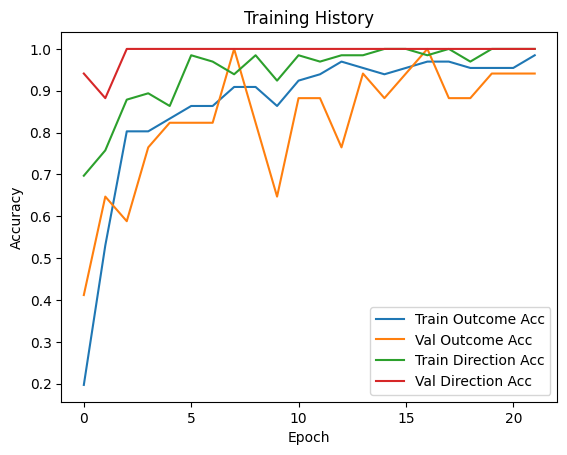

In [7]:
# === SPLIT DATA ===
X_train, X_test, y_outcome_train, y_outcome_test, y_dir_train, y_dir_test = train_test_split(
    X_images, y_outcome, y_direction, test_size=0.2, stratify=y_outcome, random_state=42
)

# === BUILD MODEL ===
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3))
base_model.trainable = False  # freeze pretrained layers

img_input = Input(shape=(*IMAGE_SIZE, 3))
x = base_model(img_input, training=False)
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

# Output heads
outcome_output = Dense(y_outcome.shape[1], activation='softmax', name='outcome')(x)
direction_output = Dense(y_direction.shape[1], activation='softmax', name='direction')(x)

model = Model(inputs=img_input, outputs=[outcome_output, direction_output])
model.compile(
    optimizer=Adam(1e-4),
    loss={'outcome': 'categorical_crossentropy', 'direction': 'categorical_crossentropy'},
    metrics={'outcome': 'accuracy', 'direction': 'accuracy'}
)

# === TRAIN MODEL ===
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    x=X_train,
    y={'outcome': y_outcome_train, 'direction': y_dir_train},
    validation_data=(X_test, {'outcome': y_outcome_test, 'direction': y_dir_test}),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop]
)

# === EVALUATE ===
results = model.evaluate(X_test, {'outcome': y_outcome_test, 'direction': y_dir_test})
print(f"\n📊 Test Accuracy — Outcome: {results[3]:.2f}, Direction: {results[4]:.2f}")

# === SAVE MODEL ===
model.save("trade_multi_output_model.keras")

# === PLOT ===
plt.plot(history.history['outcome_accuracy'], label='Train Outcome Acc')
plt.plot(history.history['val_outcome_accuracy'], label='Val Outcome Acc')
plt.plot(history.history['direction_accuracy'], label='Train Direction Acc')
plt.plot(history.history['val_direction_accuracy'], label='Val Direction Acc')
plt.legend()
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


In [ ]:
def predict_from_chart(image_path):
    # Load and preprocess image
    img = Image.open(image_path).convert('RGB').resize(IMAGE_SIZE)
    img_array = preprocess_input(np.array(img)).reshape(1, *IMAGE_SIZE, 3)

    # Predict
    pred_outcome, pred_direction = model.predict(img_array)

    # Decode predictions
    outcome_label = label_encoder.inverse_transform([np.argmax(pred_outcome)])[0]
    direction_label = direction_encoder.inverse_transform([np.argmax(pred_direction)])[0]
    outcome_conf = np.max(pred_outcome)
    direction_conf = np.max(pred_direction)

    # Display result
    print(f"📢 Suggested Direction: {direction_label.upper()} (Confidence: {direction_conf:.2f})")
    print(f"🎯 Expected Outcome: {outcome_label.upper()} (Confidence: {outcome_conf:.2f})")

    return direction_label, outcome_label, direction_conf, outcome_conf


In [ ]:
predict_from_chart("/content/image3.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
📢 Suggested Direction: BUY (Confidence: 1.00)
🎯 Expected Outcome: LOSS (Confidence: 1.00)


('buy', 'loss', np.float32(0.9999726), np.float32(0.99986637))

In [ ]:
# Load corrections
corrections = pd.read_csv('corrections.csv')
corrections = corrections.dropna(subset=['chart_image', 'label', 'direction_taken'])

# Encode new labels (with full class size)
corrections['label_enc'] = label_encoder.transform(corrections['label'])
y_outcome_new = to_categorical(corrections['label_enc'], num_classes=len(label_encoder.classes_))

corrections['direction_enc'] = direction_encoder.transform(corrections['direction_taken'])
y_direction_new = to_categorical(corrections['direction_enc'], num_classes=len(direction_encoder.classes_))


# Load images
def load_images(filenames):
    images = []
    for fname in filenames:
        path = os.path.join('/content/', fname)
        img = Image.open(path).convert('RGB').resize((224, 224))
        img_array = preprocess_input(np.array(img))
        images.append(img_array)
    return np.array(images)

X_new = load_images(corrections['chart_image'])

# Fine-tune on new example(s)
model.fit(
    x=X_new,
    y={'outcome': y_outcome_new, 'direction': y_direction_new},
    epochs=5,  # small, controlled updates
    batch_size=1
)


Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - direction_accuracy: 1.0000 - direction_loss: 1.5531e-04 - loss: 4.8247 - outcome_accuracy: 0.6667 - outcome_loss: 4.8245
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - direction_accuracy: 1.0000 - direction_loss: 1.3510e-06 - loss: 6.8241 - outcome_accuracy: 0.6667 - outcome_loss: 6.8241
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - direction_accuracy: 1.0000 - direction_loss: 5.0862e-06 - loss: 6.2275 - outcome_accuracy: 0.3333 - outcome_loss: 6.2275
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - direction_accuracy: 1.0000 - direction_loss: 1.7092e-04 - loss: 1.8451 - outcome_accuracy: 0.3333 - outcome_loss: 1.8450
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - direction_accuracy: 1.0000 - direction_loss: 5.0465e-06 - loss: 0.2554 - outcome_accuracy: 0.6667 - outcome_loss: 0.2554


In [ ]:
predict_from_chart("/content/image3.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
📢 Suggested Direction: BUY (Confidence: 1.00)
🎯 Expected Outcome: HALF_FULL (Confidence: 1.00)


('buy', 'half_full', np.float32(0.99995005), np.float32(0.9999981))

In [ ]:
import joblib

# Save encoders to file
joblib.dump(label_encoder, "label_encoder.pkl")
joblib.dump(direction_encoder, "direction_encoder.pkl")


['direction_encoder.pkl']

In [ ]:
from google.colab import files
files.download("label_encoder.pkl")
files.download("direction_encoder.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.save("trade_multi_output_model.keras")
files.download("trade_multi_output_model.keras")

files.download("T29 trades.csv")
files.download("corrections.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>